In [66]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import json
import time
import pandas as pd
import re


In [67]:
options = webdriver.ChromeOptions()
options.add_experimental_option('excludeSwitches', ['enable-logging'])
options.add_argument('--headless=new')   # headless = "blind mode"
options.add_argument('--disable-gpu')    # safer rendering

driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()),
    options=options
)


In [68]:
# game_id = input("Enter the game ID (e.g., 401671849): ")
game_id = 401671849
url = f"https://www.espn.com/nfl/game/_/gameId/{game_id}"

driver.get(url)
time.sleep(5)  # wait for JS to load


In [70]:
soup = BeautifulSoup(driver.page_source, "html.parser")
scripts = soup.find_all("script")

# Find raw JSON from the correct script block
script_text = ""
for script in scripts:
    if 'wnPrb' in script.text and 'plys' in script.text:
        script_text = script.text
        break

if not script_text:
    raise Exception("Could not find script containing wnPrb and plys")


In [ ]:
start = script_text.find('"wnPrb":{"pts":')

i = start
while i < len(script_text):
    if script_text[i] == '}':
        end = i + 1
        break
    i += 1

# Step 3: Extract the JSON string
wnprb_json_text = script_text[start:end]

print(wnprb_json_text)


======= Raw wnPrb JSON Snippet =======
"wnPrb":{"pts":{"4016718491":41.2,"40167184940":41.2,"40167184957":44.3,"40167184979":44.8,"401671849101":37.8,"401671849126":37.2,"401671849153":41.7,"401671849178":44.5,"401671849209":48.1,"401671849221":48.1,"401671849232":44.4,"401671849259":41.8,"401671849281":41.3,"401671849304":41.6,"401671849317":41.6,"401671849330":43,"401671849359":44,"401671849384":39.4,"401671849414":44,"401671849437":43.1,"401671849449":43.4,"401671849460":45.9,"401671849501":43.4,"401671849511":43.4,"401671849520":45.6,"401671849554":44.6,"401671849576":49.4,"401671849601":49.8,"401671849623":51.4,"401671849645":61.1,"401671849679":62.9,"401671849710":67.1,"401671849717":60,"401671849753":64.4,"401671849777":65.9,"401671849810":65.6,"401671849845":66.7,"401671849870":64.9,"401671849880":65,"401671849890":63.4,"401671849919":66.4,"401671849944":64.7,"401671849966":65.1,"401671849986":63.9,"4016718491009":61.9,"4016718491032":63.9,"4016718491064":62.2,"4016718491089":5

In [ ]:
# Clean header off
prefix = '"wnPrb":{"pts":{'
wnprb_clean = wnprb_json_text[len(prefix):]

matrix = []
i = 0
length = len(wnprb_clean)

while i < length:
    # Stop if we reach the end
    if wnprb_clean[i] == '}':
        break

    # === Parse ID ===
    while wnprb_clean[i] in ['"', ' ']:
        i += 1
    id_start = i
    while wnprb_clean[i] != ':':
        i += 1
    id_str = wnprb_clean[id_start:i]
    id_num = int(id_str.strip('"'))  # 🛠️ Fix: strip trailing quote

    i += 1  # skip the colon

    # === Parse PTS ===
    while wnprb_clean[i] == ' ':
        i += 1
    pts_start = i
    while i < length and wnprb_clean[i] not in [',', '}']:
        i += 1
    pts_str = wnprb_clean[pts_start:i]
    pts_val = float(pts_str)

    # Store
    matrix.append([id_num, pts_val])

    # Skip comma if there is one
    if i < length and wnprb_clean[i] == ',':
        i += 1

# Convert to DataFrame
df_pts = pd.DataFrame(matrix, columns=["id", "pts"])
print(f"Parsed {len(matrix)} entries.")
df_pts


Parsed 185 entries.
             id   pts
0    4016718491  41.2
1   40167184940  41.2
2   40167184957  44.3
3   40167184979  44.8
4  401671849101  37.8


,id,pts
0,4016718491,41.2
1,40167184940,41.2
2,40167184957,44.3
3,40167184979,44.8
4,401671849101,37.8
...,...,...
180,4016718494069,24.1
181,4016718494084,20.6
182,4016718494091,20.5
183,4016718494098,0.0


In [ ]:
# Step 1: Find start of "plys":[
plys_start = script_text.find('"plys":[')

if plys_start == -1:
    raise Exception("Could not find 'plys':[")

# Step 2: Find matching closing bracket ']'
i = plys_start
bracket_count = 0
found_start = False
length = len(script_text)

while i < length:
    char = script_text[i]

    if char == '[':
        bracket_count += 1
        found_start = True
    elif char == ']':
        bracket_count -= 1
        if found_start and bracket_count == 0:
            plys_end = i + 1  # include the closing bracket
            break
    i += 1

# Step 3: Slice the plys string
plys_text = script_text[plys_start:plys_end]

print(plys_text)  # print the first 2000 characters


======= Preview of plys block =======
"plys":[{"clck":"15:00","id":"40167184940","prd":1,"awyScr":0,"hmScr":0,"txt":"C.Little kicks 65 yards from JAX 35 to landing zone to end zone, Touchback to the MIA 20.","sq":4000,"plyTypId":"53"},{"clck":"15:00","id":"40167184957","prd":1,"awyScr":0,"hmScr":0,"txt":" R.Mostert right end to MIA 20 for no gain (F.Oluokun, A.Johnson)","sq":5700,"plyTypId":"5","cmplmntryTxt":"1st & 10 at MIA 20"},{"clck":"14:19","id":"40167184979","prd":1,"awyScr":0,"hmScr":0,"txt":" D.Achane left end to MIA 17 for -3 yards (D.Lloyd)","sq":7900,"plyTypId":"5","cmplmntryTxt":"2nd & 10 at MIA 20"},{"clck":"13:40","id":"401671849101","prd":1,"awyScr":0,"hmScr":0,"txt":" T.Tagovailoa pass short right to D.Achane pushed ob at JAX 44 for 39 yards (R.Darby)","sq":10100,"plyTypId":"24","cmplmntryTxt":"3rd & 13 at MIA 17"},{"clck":"13:04","id":"401671849126","prd":1,"awyScr":0,"hmScr":0,"txt":" T.Tagovailoa sacked at JAX 44 for 0 yards (T.Walker)","sq":12600,"plyTypId":"7","cm

In [87]:
# Clean the prefix: remove `"plys":[`
plys_clean = plys_text[len('"plys":['):]

# Make a fast lookup for pts using the parsed DataFrame
id_to_pts = dict(zip(df_pts["id"], df_pts["pts"]))

# Initialize final matrix
final_matrix = []

i = 0
length = len(plys_clean)

while i < length:
    # Stop at end of list
    if plys_clean[i] == ']':
        break

    # === Find the next play object ===
    if plys_clean[i] != '{':
        i += 1
        continue

    obj_start = i
    brace_count = 0
    while i < length:
        if plys_clean[i] == '{':
            brace_count += 1
        elif plys_clean[i] == '}':
            brace_count -= 1
            if brace_count == 0:
                obj_end = i + 1
                break
        i += 1

    obj_str = plys_clean[obj_start:obj_end]

    # === Extract fields manually ===
    id_match = re.search(r'"id":"?(\d+)"?', obj_str)
    clck_match = re.search(r'"clck":"([^"]+)"', obj_str)
    prd_match = re.search(r'"prd":(\d+)', obj_str)

    if id_match:
        id_val = int(id_match.group(1))
        if id_val in id_to_pts:
            clck_val = clck_match.group(1) if clck_match else None
            prd_val = int(prd_match.group(1)) if prd_match else None
            final_matrix.append([id_val, prd_val, clck_val, id_to_pts[id_val]])

# Convert to DataFrame
df_final = pd.DataFrame(final_matrix, columns=["id", "prd", "clck", "pts"])
print(f"Total matched entries: {len(df_final)}")
df_final

Total matched entries: 184


,id,prd,clck,pts
0,40167184940,1,15:00,41.2
1,40167184957,1,15:00,44.3
2,40167184979,1,14:19,44.8
3,401671849101,1,13:40,37.8
4,401671849126,1,13:04,37.2
...,...,...,...,...
179,4016718494069,4,0:20,24.1
180,4016718494084,4,0:04,20.6
181,4016718494091,4,0:04,20.5
182,4016718494098,4,0:00,0.0


In [88]:
# Function to convert prd and clck (e.g., "15:00") to seconds elapsed
def compute_time_seconds(prd, clck):
    if clck is None or prd is None:
        return None
    try:
        minutes, seconds = map(int, clck.strip().split(":"))
        quarter_offset = (prd - 1) * 900
        clock_remaining = minutes * 60 + seconds
        time_elapsed = quarter_offset + (900 - clock_remaining)
        return time_elapsed
    except:
        return None

# Apply to DataFrame
df_final["time_sec"] = df_final.apply(lambda row: compute_time_seconds(row["prd"], row["clck"]), axis=1)

# Preview
df_final = df_final.sort_values("time_sec").reset_index(drop=True)
print(df_final.head())


             id  prd   clck   pts  time_sec
0   40167184940    1  15:00  41.2         0
1   40167184957    1  15:00  44.3         0
2  401671849717    1  14:57  60.0         3
3   40167184979    1  14:19  44.8        41
4  401671849101    1  13:40  37.8        80


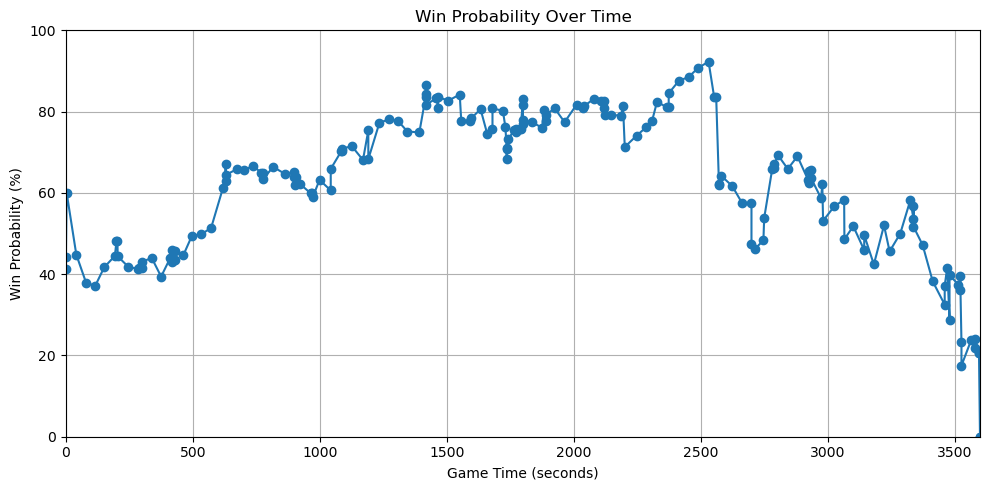

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_final["time_sec"], df_final["pts"], marker='o', linestyle='-')

plt.title("Win Probability Over Time")
plt.xlabel("Game Time (seconds)")
plt.ylabel("Win Probability (%)")

plt.xlim(0, 3600)  # ⏱️ time from 0 to 3600 sec
plt.ylim(0, 100)   # 📈 probability from 0% to 100%

plt.grid(True)
plt.tight_layout()
plt.show()
